In [1]:
import xgboost
xgboost.__version__

'3.1.0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
train_df = pd.read_csv('titanic/train.csv')
test_df = pd.read_csv('titanic/test.csv')

In [13]:
train_df = train_df.drop('Cabin',axis=1)
test_df = test_df.drop('Cabin',axis=1)

In [14]:
train_df['Embarked'] = train_df['Embarked'].fillna('S') # embarked 컬럼 결측값 S로 채워 넣기(S의 수가 가장 많음)
test_df['Embarked'] = test_df['Embarked'].fillna('S')

In [15]:
train_df = train_df.drop(['PassengerId','Name','Ticket'],axis=1)
test_df = test_df.drop(['Name','Ticket'],axis=1)

In [16]:
test_df['Fare'] = test_df['Fare'].dropna()

In [18]:
train_df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [38]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())

In [21]:
map_col = {'S' : 0,
           'C' : 1,
           'Q' : 2}

map_col2 = {'male' : 0,
            'female' : 1
           }
train_df['Embarked'] = train_df['Embarked'].map(map_col)
train_df['Sex'] = train_df['Sex'].map(map_col2)

In [22]:
X = train_df.drop('Survived',axis=1)
y = train_df['Survived']

### 연습문제. 랜덤포레스트

타이타닉 데이터에 대하여 

1. 랜덤포레스트 모델로 학습/예측/성능제시/피처중요도 시각화하시오.

- n_estimators = 100

In [27]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

print(f' accuracy : {accuracy_score(y_test,rf_clf.predict(X_test))}')

 accuracy : 0.776536312849162


In [28]:
import optuna

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',100,200)
    max_depth = trial.suggest_int('max_depth',8,24)
    min_samples_split = trial.suggest_int('min_samples_split',2,16)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 12)

    rf_clf = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split = min_samples_split,
                                    min_samples_leaf = min_samples_leaf,
                                    random_state=2020158011)
    scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f'best hyperparameter : {study.best_params}')
print(f'best roc auc score : {study.best_value}')

[I 2025-10-21 16:36:02,543] A new study created in memory with name: no-name-049fc147-714e-4ef7-a4c5-6fe963be8d84
[I 2025-10-21 16:36:03,217] Trial 0 finished with value: 0.8503049433731251 and parameters: {'n_estimators': 165, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8503049433731251.
[I 2025-10-21 16:36:03,687] Trial 1 finished with value: 0.8453282828282829 and parameters: {'n_estimators': 105, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8503049433731251.
[I 2025-10-21 16:36:04,334] Trial 2 finished with value: 0.8493851392715029 and parameters: {'n_estimators': 160, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8503049433731251.
[I 2025-10-21 16:36:04,896] Trial 3 finished with value: 0.8507671411080502 and parameters: {'n_estimators': 143, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 3 with value

best hyperparameter : {'n_estimators': 141, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 11}
best roc auc score : 0.8529836241199877


2. 하이퍼파라미터를 튜닝하여 최적의 모델을 찾아 예측 성능을 제시하고, 피처중요도도 시각화하시오.

```python
params = {'n_estimators':[100, 200],
          'max_depth':[8, 16, 24],
          'min_samples_split':[2, 8, 16],
          'min_samples_leaf':[1, 6, 12]
         }
```

In [37]:
study.best_value

0.8529836241199877

In [29]:
best_model = study.best_params

In [30]:
rf_clf = RandomForestClassifier(**best_model)

In [31]:
rf_clf.fit(X_train, y_train)

,n_estimators,141
,criterion,'gini'
,max_depth,15
,min_samples_split,7
,min_samples_leaf,11
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
rf_clf.predict(X_test)

array([0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0])

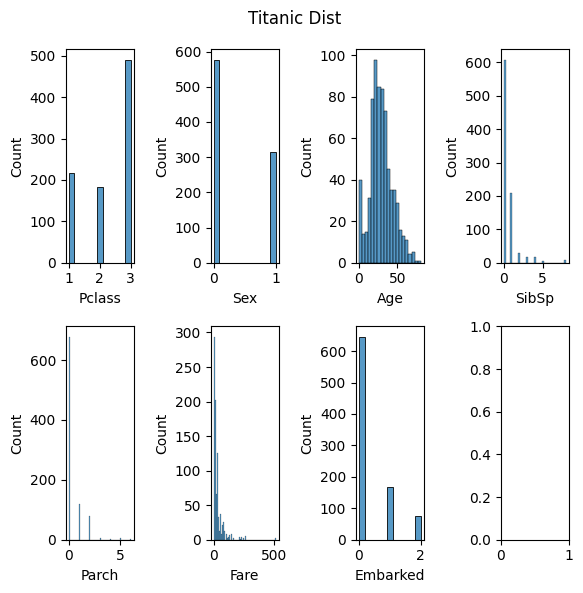

In [36]:
nrows, ncols= 2, 4
fig,axs=plt.subplots(nrows=nrows, ncols=ncols, figsize=(6,6))
for i, ftr in enumerate(X.columns):
    rows, col = i//ncols, i %ncols
    sns.histplot(X[ftr], ax=axs[rows][col])
plt.suptitle('Titanic Dist')
plt.tight_layout()
plt.show()